In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataloader block

In [2]:
import numpy as np
import h5py
from torch.utils import data


class MelSpecDataset(data.Dataset):
    def __init__(self, dir=''):
        self.dir = dir
        self.f = h5py.File(dir, 'r')
        self.dataset = self.f['dataset']

    def __getitem__(self, idx):
        point = self.dataset['data'][idx, :, :]
        label = self.dataset['label'][idx, :]

        return np.array(point).astype('float32'), np.array(label).astype('float32')

    def __len__(self):
        return self.dataset['data'].shape[0]


def split_ids(dir='', split_r=0.3, shuffle=True):
    f = h5py.File(dir, 'r')
    dataset = f['dataset']
    N, B, T = dataset['data'].shape
    val_n = int(N*split_r)
    if shuffle:
        val_split = np.random.randint(0, N, val_n)
        mask = np.ones(N, dtype=bool)
        mask[val_split] = False
        tr_split = np.arange(0, N)[mask]
    else:
        val_split = np.arange(0, val_n)
        tr_split = np.arange(val_n, N)

    f.close()
    return tr_split, val_split

Feature batch shape: torch.Size([128, 96, 96])
Labels batch shape: torch.Size([128, 1000])


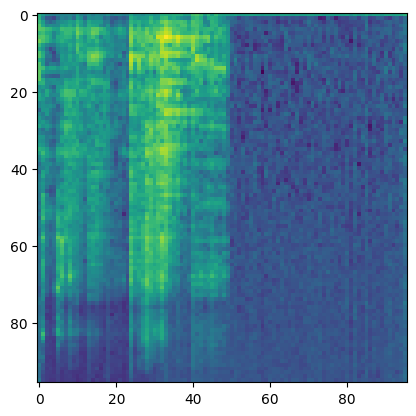

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0

In [ ]:
def try_dataloader():
    import matplotlib.pyplot as plt
    split_r = 0.3
    split_shuffle = True
    load_shuffle = True
    batch_size = 128
    train_data_path = '/content/drive/MyDrive/ID2223/project/data/spec_tags_top_1000'
    test_data_path = '/content/drive/MyDrive/ID2223/project/data/spec_tags_top_1000_val'

    tr_split, val_split = split_ids(dir=train_data_path, split_r=split_r,
                                    shuffle=split_shuffle)

    full_set = MelSpecDataset(dir=train_data_path)
    train_set = data.Subset(full_set, tr_split)
    validation_set = data.Subset(full_set, val_split)
    train_loader = data.DataLoader(dataset=train_set, shuffle=load_shuffle, batch_size=batch_size)
    validation_loader = data.DataLoader(dataset=validation_set, shuffle=load_shuffle, batch_size=batch_size)

    test_set = MelSpecDataset(dir=test_data_path)
    test_loader = data.DataLoader(dataset=test_set, shuffle=load_shuffle, batch_size=batch_size)

    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img, cmap="viridis")
    plt.show()
    print(f"Label: {label}")

try_dataloader()

## Model block

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, num_class=1000):
        super(ConvNet, self).__init__()

        # init bn
        self.bn_init = nn.BatchNorm2d(1)

        # layer 1
        self.conv_1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.mp_1 = nn.MaxPool2d(2) # 48

        # layer 2
        self.conv_2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.mp_2 = nn.MaxPool2d(2) # 24

        # layer 3
        self.conv_3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(256)
        self.mp_3 = nn.MaxPool2d(2) # 12

        # layer 4
        self.conv_4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(256)
        self.mp_4 = nn.MaxPool2d(3) # 4
        # flatten (256x4x4)

        # # classifier
        self.dense_1 = nn.Linear(4096, 4096)
        self.dense_2 = nn.Linear(4096, num_class)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x.unsqueeze(1)
        # print(x.size())

        # init bn
        x = self.bn_init(x)

        # layer 1
        x = self.mp_1(nn.ReLU()(self.bn_1(self.conv_1(x))))
        # print(x.size())

        # layer 2
        x = self.mp_2(nn.ReLU()(self.bn_2(self.conv_2(x))))
        # print(x.size())

        # layer 3
        x = self.mp_3(nn.ReLU()(self.bn_3(self.conv_3(x))))
        # print(x.size())

        # layer 4
        x = self.mp_4(nn.ReLU()(self.bn_4(self.conv_4(x))))
        # print(x.size())

        # classifier
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        x = nn.ReLU()(self.dense_1(x))
        logit = nn.Sigmoid()(self.dense_2(x))

        return logit



## Solver Block

In [4]:
import numpy as np
import torch
from torch.utils import data
from sklearn import metrics
import pickle


class Solver(object):
    def __init__(self, epochs=2, lr=0.0001, split_r=0.3, batch_size=128,
                 tr_test_state='', resume_training=False, tag_translate=[],
                 save_checkpoint_path='', save_best_model_path='', data_dir='',
                 test_log_path='', debug=False):

        assert tr_test_state in ['train', 'test']
        self.batch_size = batch_size
        self.tr_test_state = tr_test_state
        self.is_cuda = torch.cuda.is_available()
        self.save_best_model_path = save_best_model_path
        self.data_dir = data_dir
        self.debug = debug
        self.lr = lr
        self.epochs = epochs
        self.split_r = split_r
        self.resume_training = resume_training
        self.save_checkpoint_path = save_checkpoint_path

        self._build_model()

        if self.tr_test_state == 'train':
            if self.resume_training:
                self._load_checkpoint()
            else:
                tr_split, val_split = split_ids(dir=self.data_dir, split_r=self.split_r)
                self.train_split = tr_split
                self.validation_split = val_split
                self.save_epoch = 0
                self.t_loss = []
                self.v_loss = []
                self.best_stat = 0

            self._fetch_tr_loaders()
            self.model.train()

        if self.tr_test_state == 'test':
            self.test_log_path = test_log_path
            m = torch.load(self.save_best_model_path)
            self.model.load_state_dict(m['model'])
            self._fetch_test_loader()
            self.model.eval()

    def _build_model(self):
        model = ConvNet(num_class=1000)
        self.model = model
        if self.is_cuda:
            self.model.cuda()

        optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        self.optimizer = optimizer

    def _fetch_tr_loaders(self):
        full_set = MelSpecDataset(dir=self.data_dir)
        train_set = data.Subset(full_set, self.train_split)
        validation_set = data.Subset(full_set, self.validation_split)
        train_set = self._to_debug(train_set)
        validation_set = self._to_debug(validation_set)
        tr_loader = data.DataLoader(dataset=train_set, shuffle=True, batch_size=self.batch_size)
        val_loader = data.DataLoader(dataset=validation_set, shuffle=True, batch_size=self.batch_size)

        self.data_loader = tr_loader
        self.validation_loader = val_loader

    def _fetch_test_loader(self):
        test_set = MelSpecDataset(dir=self.data_dir)
        test_set = self._to_debug(test_set)
        test_loader = data.DataLoader(dataset=test_set, shuffle=True, batch_size=self.batch_size)

        self.data_loader = test_loader

    def _to_debug(self, dataset):
        debug_size = 5
        if self.debug:
            dataset = data.Subset(dataset, np.arange(debug_size*self.batch_size))

        return dataset

    def _load_checkpoint(self):
        checkpoint = torch.load(self.save_checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.save_epoch = checkpoint['epoch']
        self.v_loss = checkpoint['v_loss']
        self.t_loss = checkpoint['t_loss']
        self.train_split = checkpoint['tr_split']
        self.validation_split = checkpoint['val_split']
        self.best_stat = checkpoint['best_stat']

        print(f'loaded checkpoint. Next ep: {self.save_epoch}')

    def _save_checkpoint(self, curr_epoch):
        torch.save({
            'epoch': curr_epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            't_loss': self.t_loss,
            'v_loss': self.v_loss,
            'tr_split': self.train_split,
            'val_split': self.validation_split,
            'best_stat': self.best_stat
            }, self.save_checkpoint_path + f"EP{curr_epoch}")

    def _to_cuda(self, x):
        if self.is_cuda:
            x = x.cuda()
        return x

    def train(self):
        assert self.tr_test_state == 'train'

        reconst_loss = torch.nn.BCELoss()
        for epoch in range(self.save_epoch, self.epochs):
            self.model.train()
            running_loss = 0
            b = 0
            for x, y in iter(self.data_loader):
                x = self._to_cuda(x)
                y = self._to_cuda(y)

                # predict
                out = self.model(x)
                loss = reconst_loss(out, y)

                # back propagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                b += 1
                print(f'tr epoch {epoch}/{self.epochs-1}, batch {b}/{len(self.data_loader)}')

            ep_loss = running_loss/len(self.data_loader)
            print(f'loss {ep_loss}')
            self.t_loss.append(ep_loss)

            if epoch % 5 == 0:
                print(f'in val + save clause, ep: {epoch}')
                _, _, roc, _, _ = self._validation()

                if roc >= self.best_stat:
                    print(f'best model updated. ROC AUC old {self.best_stat}, new {roc}')
                    self.best_stat = roc
                    m = self.model.state_dict()
                    torch.save({'model': m}, self.save_best_model_path)

                self._save_checkpoint(curr_epoch=epoch)

    def _validation(self):
        prd_array = []  # prediction
        gt_array = []   # ground truth
        self.model.eval()
        reconst_loss = torch.nn.BCELoss()

        running_loss = 0
        b = 0
        for x, y in iter(self.validation_loader):
            # variables to cuda
            x = self._to_cuda(x)
            y = self._to_cuda(y)

            # predict
            out = self.model(x)
            loss = reconst_loss(out, y)

            out = out.detach().cpu()
            y = y.detach().cpu()

            running_loss += loss.item()
            b += 1
            print(f'val batch {b}/{len(self.validation_loader)}')

            for prd in out:
                prd_array.append(list(np.array(prd)))
            for gt in y:
                gt_array.append(list(np.array(gt)))

        v_loss = running_loss/len(self.validation_loader)
        print(f'loss {v_loss}')
        self.v_loss.append(v_loss)

        pr_auc_ma, pr_auc_mi, roc_auc_ma, roc_auc_mi, acc = self._calc_stats(prd_array, gt_array)

        return pr_auc_ma, pr_auc_mi, roc_auc_ma, roc_auc_mi, acc

    def _calc_stats(self, prd_array, gt_array):
        prd_array = np.array(prd_array)
        gt_array = np.array(gt_array)

        roc_auc_ma = 0
        roc_auc_mi = 0
        pr_auc_ma = 0
        pr_auc_mi = 0

        if not self.debug:
            roc_auc_ma = metrics.roc_auc_score(gt_array, prd_array, average='macro')
            roc_auc_mi = metrics.roc_auc_score(gt_array, prd_array, average='micro')

            pr_auc_ma = metrics.average_precision_score(gt_array, prd_array, average='macro')
            pr_auc_mi = metrics.average_precision_score(gt_array, prd_array, average='micro')

        prd_cls = prd_array > 0.5
        prd_cls.astype('float32')
        acc = metrics.accuracy_score(gt_array, prd_cls)

        return pr_auc_ma, pr_auc_mi, roc_auc_ma, roc_auc_mi, acc

    def test(self):
        assert self.tr_test_state == 'test', "create a new solver for testing"

        reconst_loss = torch.nn.BCELoss()
        prd_array = []  # prediction
        gt_array = []   # ground truth

        running_loss = 0
        b = 0
        for x, y in iter(self.data_loader):
            # variables to cuda
            x = self._to_cuda(x)
            y = self._to_cuda(y)

            # predict
            out = self.model(x)
            loss = reconst_loss(out, y)

            running_loss += loss.item()
            b += 1
            print(f'test batch {b}/{len(self.data_loader)}')

            # append prediction
            out = out.detach().cpu()
            y = y.detach().cpu()
            for prd in out:
                prd_array.append(list(np.array(prd)))
            for gt in y:
                gt_array.append(list(np.array(gt)))

        print(f'loss {running_loss/len(self.data_loader)}')

        pr_auc_ma, pr_auc_mi, roc_auc_ma, roc_auc_mi, acc = self._calc_stats(prd_array, gt_array)

        # write to file
        log_file = self.test_log_path + 'log.txt'
        prd_file = self.test_log_path + 'prd.npy'
        gt_file = self.test_log_path + 'gt.npy'

        with open(log_file, 'w') as f:
            f.write(str(pr_auc_ma) + '\n')
            f.write(str(pr_auc_mi) + '\n')
            f.write(str(roc_auc_ma) + '\n')
            f.write(str(roc_auc_mi) + '\n')
            f.write(str(acc) + '\n')

        with open(prd_file, 'wb') as f:
            np.save(f, prd_array)

        with open(gt_file, 'wb') as f:
            np.save(f, gt_array)

### Example use (debug)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  3 14:50:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
checkpoint = ''
model = 'model'

checkpoint_path = '/content/drive/MyDrive/ID2223/project/checkpoints/' + checkpoint
model_path = '/content/drive/MyDrive/ID2223/project/best_model/' + model
train_data_path = '/content/drive/MyDrive/ID2223/project/data/spec_tags_top_1000'
test_data_path = '/content/drive/MyDrive/ID2223/project/data/spec_tags_top_1000_val'
test_log_path = '/content/drive/MyDrive/ID2223/project/logs/'

In [ ]:
def train(checkpoint_path, model_path, data_path, debug=True):
    tr_solver = Solver(epochs=1, lr=0.0001, split_r=0.3, batch_size=128,
                       tr_test_state='train', resume_training=False,
                       tag_translate=[], save_checkpoint_path=checkpoint_path,
                       save_best_model_path=model_path, data_dir=data_path,
                       debug=debug)
    tr_solver.train()

In [ ]:
train(checkpoint_path=checkpoint_path, model_path=model_path, data_path=train_data_path, debug=True)

tr epoch 0/0, batch 1/5
tr epoch 0/0, batch 2/5
tr epoch 0/0, batch 3/5
tr epoch 0/0, batch 4/5
tr epoch 0/0, batch 5/5
loss 0.403656879067421
in val + save clause, ep: 0
val batch 1/5
val batch 2/5
val batch 3/5
val batch 4/5
val batch 5/5
loss 0.5980473041534424


In [ ]:
def cont_train(checkpoint_path, model_path, data_path, debug=True):
    tr_solver = Solver(epochs=2, lr=0.0001, split_r=0.3, batch_size=128,
                       tr_test_state='train', resume_training=True,
                       tag_translate=[], save_checkpoint_path=checkpoint_path,
                       save_best_model_path=model_path, data_dir=data_path,
                       debug=debug)
    tr_solver.train()

In [ ]:
checkpoint_path = checkpoint_path + 'EP0'

In [ ]:
cont_train(checkpoint_path=checkpoint_path, model_path=model_path, data_path=train_data_path, debug=True)

loaded checkpoint. Next ep: 1
tr epoch 1/1, batch 1/5
tr epoch 1/1, batch 2/5
tr epoch 1/1, batch 3/5
tr epoch 1/1, batch 4/5
tr epoch 1/1, batch 5/5
loss 0.03678875379264355


In [ ]:
def test(model_path, data_path, test_log_path, debug=True):
    test_solver = Solver(batch_size=128,
                         tr_test_state='test',
                         tag_translate=[],
                         save_best_model_path=model_path, data_dir=data_path,
                         test_log_path=test_log_path, debug=debug)
    test_solver.test()

In [ ]:
test(model_path=model_path, data_path=test_data_path, test_log_path=test_log_path, debug=True)

test batch 1/5
test batch 2/5
test batch 3/5
test batch 4/5
test batch 5/5
loss 0.5979959845542908


### True use

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  3 19:30:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              32W /  70W |   5775MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
checkpoint = ''
model = 'model'

checkpoint_path = '/content/drive/MyDrive/ID2223/project/checkpoints/' + checkpoint
model_path = '/content/drive/MyDrive/ID2223/project/best_model/' + model
train_data_path = '/content/drive/MyDrive/ID2223/project/data/spec_tags_top_1000'
test_data_path = '/content/drive/MyDrive/ID2223/project/data/spec_tags_top_1000_val'
test_log_path = '/content/drive/MyDrive/ID2223/project/logs/'

debug = False


In [ ]:
def train(checkpoint_path, model_path, data_path, debug=True):
    tr_solver = Solver(epochs=101, lr=0.001, split_r=0.3, batch_size=128,
                       tr_test_state='train', resume_training=False,
                       tag_translate=[], save_checkpoint_path=checkpoint_path,
                       save_best_model_path=model_path, data_dir=data_path,
                       debug=debug)
    tr_solver.train()

Only run train() beneath until one checkpoint

In [ ]:
#train(checkpoint_path=checkpoint_path, model_path=model_path, data_path=train_data_path, debug=debug)

Continue training from checkpoint

In [ ]:
def cont_train(checkpoint_path, model_path, data_path, debug=True):
    tr_solver = Solver(epochs=101, lr=0.001, split_r=0.3, batch_size=128,
                       tr_test_state='train', resume_training=True,
                       tag_translate=[], save_checkpoint_path=checkpoint_path,
                       save_best_model_path=model_path, data_dir=data_path,
                       debug=debug)
    tr_solver.train()

In [ ]:
# add most recent checkpoint, from where to start
checkpoint_path = checkpoint_path + 'EP0EP5EP20'
print(checkpoint_path)

/content/drive/MyDrive/ID2223/project/checkpoints/EP0EP5EP20


In [ ]:
cont_train(checkpoint_path=checkpoint_path, model_path=model_path, data_path=train_data_path, debug=debug)

loaded checkpoint. Next ep: 51
21839466
51
11


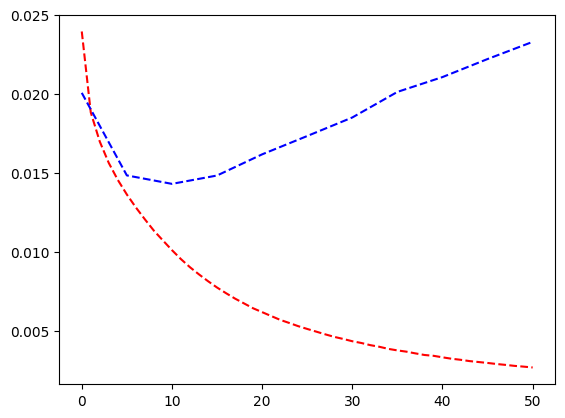

In [ ]:
def status_check(checkpoint_path, model_path, data_path, debug=True):
    import matplotlib.pyplot as plt

    status_solver = Solver(epochs=101, lr=0.001, split_r=0.3, batch_size=128,
                       tr_test_state='train', resume_training=True,
                       tag_translate=[], save_checkpoint_path=checkpoint_path,
                       save_best_model_path=model_path, data_dir=data_path,
                       debug=debug)

    #pytorch_total_params = sum(p.numel() for p in status_solver.model.parameters() if p.requires_grad)
    #print(pytorch_total_params)

    vy = status_solver.v_loss
    ty = status_solver.t_loss

    print(len(ty))
    print(len(vy))
    r = 5
    vx = np.arange(0,len(vy)) * r
    tx = np.arange(0,len(ty))
    #vx = np.repeat(vals, repeats)

    plt.plot(tx, ty, 'r--', vx, vy, 'b--')
status_check(checkpoint_path='/content/drive/MyDrive/ID2223/project/checkpoints/EP0EP5EP20EP50', model_path=model_path, data_path=train_data_path, debug=False)

## Test

In [11]:
test_data_path = '/content/drive/MyDrive/ID2223/project/data/spec_tags_top_1000_val'
model_path = '/content/drive/MyDrive/ID2223/project/best_model/model'
test_log_path = '/content/drive/MyDrive/ID2223/project/logs/'
debug = False

In [12]:
def test(model_path, data_path, test_log_path, debug=True):
    test_solver = Solver(batch_size=128,
                         tr_test_state='test',
                         tag_translate=[],
                         save_best_model_path=model_path, data_dir=data_path,
                         test_log_path=test_log_path, debug=debug)
    test_solver.test()

In [13]:
test(model_path=model_path, data_path=test_data_path, test_log_path=test_log_path, debug=debug)

test batch 1/150
test batch 2/150
test batch 3/150
test batch 4/150
test batch 5/150
test batch 6/150
test batch 7/150
test batch 8/150
test batch 9/150
test batch 10/150
test batch 11/150
test batch 12/150
test batch 13/150
test batch 14/150
test batch 15/150
test batch 16/150
test batch 17/150
test batch 18/150
test batch 19/150
test batch 20/150
test batch 21/150
test batch 22/150
test batch 23/150
test batch 24/150
test batch 25/150
test batch 26/150
test batch 27/150
test batch 28/150
test batch 29/150
test batch 30/150
test batch 31/150
test batch 32/150
test batch 33/150
test batch 34/150
test batch 35/150
test batch 36/150
test batch 37/150
test batch 38/150
test batch 39/150
test batch 40/150
test batch 41/150
test batch 42/150
test batch 43/150
test batch 44/150
test batch 45/150
test batch 46/150
test batch 47/150
test batch 48/150
test batch 49/150
test batch 50/150
test batch 51/150
test batch 52/150
test batch 53/150
test batch 54/150
test batch 55/150
test batch 56/150
t